# Part 1 Sequence Tagging: NER


## Q1.1 Word Embedding

### Q1.1.1 Download Dependency

In [1]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


### Q1.1.2 Download the pretrained word2vec embeddings 

In [2]:
import gensim.downloader
import numpy as np
import pandas as pd
import csv
import random
import tqdm
import time
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from seqeval.metrics import f1_score

#Download the embeddings "word2vec-google-news-300"
w2v = gensim.downloader.load('word2vec-google-news-300')

---
### Question 1.1
###### Based on word2vec embeddings you have downloaded, use cosine similarity to find the most similar word to each of these words: (a) “student”; (b) “Apple”; (c) “apple”. Report the most similar word and its cosine similarity.

In [3]:
def get_word_and_cosine_similarity(word:list, top_n:int):
    result = {}
    for w in word:
        similarities = w2v.cosine_similarities(w2v[w], w2v.vectors)
        sorted_similarities = sorted(similarities[:], reverse=True)[:top_n+1]
        result[w] = [(w2v.index_to_key[np.where(similarities == s)[0][0]], s) for s in sorted_similarities if w2v.index_to_key[np.where(similarities == s)[0][0]]!=w]
    return result

In [4]:
word_list = ["student", "Apple", "apple"]
print("Most similar word and its cosine similarity by using .most_similar(): ")
for word in word_list:
    print(word+'\t', w2v.most_similar(word,topn=1))

print("\nMost similar word and its cosine similarity by using .cosine_similarities(): ")
r = get_word_and_cosine_similarity(word_list, 1)
for k,v in r.items():
    print(k+'\t', v)

Most similar word and its cosine similarity by using .most_similar(): 
student	 [('students', 0.7294867038726807)]
Apple	 [('Apple_AAPL', 0.7456986308097839)]
apple	 [('apples', 0.720359742641449)]

Most similar word and its cosine similarity by using .cosine_similarities(): 
student	 [('students', 0.7294867)]
Apple	 [('Apple_AAPL', 0.74569863)]
apple	 [('apples', 0.72035974)]


---
### 1.2 Data
###### Then you can start to prepare the dataset. For NER, you will work with [CoNLL2003](https://github.com/TheAnig/NER-LSTM-CNN-Pytorch/tree/master/data) (click and download “eng.testa”, “eng.testb”, “eng.train”). Before training, you need to preprocess the dataset such that each of them contains a training file, a development file and a test file. The development file is used to select the best model during training. The test file is used for final evaluation. For CoNLL2003, the training, development and test file corresponds to “eng.train”, “eng.testa” and “eng.testb”, respectively. Note that you only need to use the first and the last column of each line corresponding to the input word and the word label, respectively. A screenshot of the data is shown in Figure 1. In this example, there are two sentences (separated by ‘\n’). The input for each sentence is composed of the words from the first column. For example, the first sentence in Figure 1 corresponds to “CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY.” The label for each of the first 3 words CRICKET, -, LERCESTERSHIRE corresponds to ‘O’, ‘O’, ‘I-ORG’, respectively

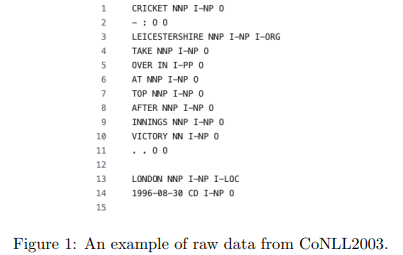

In [5]:
# Define the file paths
train_file = "data/Part 1/eng.train"
verification_file = "data/Part 1/eng.testa"
test_file = "data/Part 1/eng.testb"

# Function to read and process a CoNLL2003 file and returns df
def process_files(file_path, csv_name):
    """ Parameters:
        - file_path: CoNLL2003 files
        - csv_name: Bool
             returns pd file, columns: ["Sentence Number", "Word", "NEr tag"]
    """
    data = []
    sentence_no = 1
    with open(file_path, 'r', encoding='utf-8') as file:
        for row in file:
            line = row.strip()
            if not line:  # Empty line indicates end of a sentence
                sentence_no += 1
            else:
                ner = line.split(" ")
                # ensuring that for each data there is a word and the word's NER label
                assert all([ner[i] for i in range(4)])
                data.append([sentence_no, ner[0], ner[3]])

    with open(csv_name, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Sentence Number", "Word", "NEr tag"])
        for word in data:
            writer.writerow([word[0], word[1], word[2]])
    return pd.read_csv(csv_name)

# Function to load existing csv file if have
def load_files(file_name):
    return pd.read_csv(file_name)

# Process the data files
train_df = process_files(train_file, csv_name="data/Part 1/train_data.csv")
validation_df = process_files(verification_file, csv_name="data/Part 1/verification_data.csv")
test_df = process_files(test_file, csv_name="data/Part 1/test_data.csv")

### Question 1.2
###### (a) Describe the size (number of sentences) of the training, development and test file for CoNLL2003. Specify the complete set of all possible word labels based on the tagging scheme (IO, BIO, etc.) you chose.

In [6]:
file_labels = ["Training", "Verification", "Test"]
for i, df in enumerate([train_df, validation_df, test_df]):
    print("="*100)
    print(f"{file_labels[i]} data information")
    print(f"> Number of sentences:    {df['Sentence Number'].max()}")
    print(f"> Count of Unique words:  {len(df['Word'].unique())}")
    print(f"> Type of tags:           {sorted(df['NEr tag'].unique())}\n")
print("="*100,'\n')

print("With the given shapes, parameters and type of tags exists, we select the tagging scheme to be BIO as it has B,I,O tags.")

Training data information
> Number of sentences:    14987
> Count of Unique words:  23623
> Type of tags:           ['B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

Verification data information
> Number of sentences:    3466
> Count of Unique words:  9966
> Type of tags:           ['B-MISC', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

Test data information
> Number of sentences:    3684
> Count of Unique words:  9489
> Type of tags:           ['B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


With the given shapes, parameters and type of tags exists, we select the tagging scheme to be BIO as it has B,I,O tags.


###### (b) Choose an example sentence from the training set of CoNLL2003 that has at least two named entities with more than one word. Explain how to form complete named entities from the label for each word, and list all the named entities in this sentence.

In [7]:
def q1b(df):
    while True:
        # Keeps track of number of entities
        count =0
        
        # Generate a random sentence number
        rand = random.randint(1,df['Sentence Number'].iloc[-1]+1)

        # Filter df by sentence_number
        mask = df['Sentence Number'] == rand
        rand_df = df[mask].reset_index()

        # Check is to ensure we do not double count consecutive word with same tag
        check = None

        # Check through dataframe and count number of entities
        for x in range(len(rand_df['NEr tag'])):
            if x < len(rand_df['NEr tag'])-1:
                
                # Check current tag !='O'
                if rand_df['NEr tag'].iloc[x]!='O':
                    
                    # Check if current tag starts with 'B-'
                    if rand_df['NEr tag'].iloc[x].startswith('B-'):
                        
                        # Strip current tag of 'B-' and next tag of 'I-'
                        if rand_df['NEr tag'].iloc[x].strip('B-') == rand_df['NEr tag'].iloc[x+1].strip('I-'):
                            
                             # updating check if tags are the same 
                            if check == rand_df['NEr tag'].iloc[x-1]:
                                check = rand_df['NEr tag'].iloc[x]

                            # Incrementing count and updating check
                            else:
                                count+=1
                                check = rand_df['NEr tag'].iloc[x]
                
                
                    #Check if current tag == next tag
                    elif rand_df['NEr tag'].iloc[x+1] == rand_df['NEr tag'].iloc[x]:

                        # updating check if tags are the same 
                        if check == rand_df['NEr tag'].iloc[x-1]:
                            check = rand_df['NEr tag'].iloc[x]

                        # Incrementing count and updating check
                        else:
                            count+=1
                            check = rand_df['NEr tag'].iloc[x]

                # Reinitialise check to None once 'O' detected to ensure other different named entities of same tag as previous is counted.
                elif rand_df['NEr tag'].iloc[x]=='O':
                    check = None

                # Return once count >=2
                if count >=2:
                    return rand_df          

def process(df):
    sentence = ''
    tag = ''
    sen_and_tag = ''
    for x in range (len(df['Word'])):
        sentence += str(df['Word'].iloc[x])
        sentence+= ' '
        tag += str(df['NEr tag'].iloc[x])
        tag+=' '
        sen_and_tag +=str(df['Word'].iloc[x])
        sen_and_tag +='/'
        sen_and_tag += str(df['Word'].iloc[x])
        sen_and_tag += ' '
    print(f"sentence: {sentence}")
    print(f"tag: {tag}")
    print(f"sentence with tag: {sen_and_tag}")   

q1b_df = q1b(train_df)      
process(q1b_df)

sentence: 1 - Arantxa Sanchez Vicario ( Spain ) beat Katarina Studenikova 
tag: O O I-PER I-PER I-PER O I-LOC O O I-PER I-PER 
sentence with tag: 1/1 -/- Arantxa/Arantxa Sanchez/Sanchez Vicario/Vicario (/( Spain/Spain )/) beat/beat Katarina/Katarina Studenikova/Studenikova 


In [8]:
def check(df):
    # Keeps track of number of entities
    count =0
    
    # Check is to ensure we do not double count consecutive word with same tag
    check = None

    # Check through dataframe and count number of entities
    for x in range(len(df['NEr tag'])):
        if x < len(df['NEr tag'])-1:
            # Check tag !='O', next tag is same as current tag 
            if df['NEr tag'].iloc[x]!='O':
                if df['NEr tag'].iloc[x].startswith('B-'):
                    if df['NEr tag'].iloc[x].strip('B-') == df['NEr tag'].iloc[x+1].strip('I-'):
                            # updating check if tags are the same 
                        if check == df['NEr tag'].iloc[x-1]:
                            check = df['NEr tag'].iloc[x]

                        # Incrementing count and updating check
                        else:
                            count+=1
                            check = df['NEr tag'].iloc[x]
            
            
            
                elif df['NEr tag'].iloc[x+1] == df['NEr tag'].iloc[x]:

                    # updating check if tags are the same 
                    if check == df['NEr tag'].iloc[x-1]:
                        check = df['NEr tag'].iloc[x]

                    # Incrementing count and updating check
                    else:
                        count+=1
                        check = df['NEr tag'].iloc[x]

            # Reinitialise check to None once 'O' detected to ensure other different named entities of same tag as previous is counted.
            elif df['NEr tag'].iloc[x]=='O':
                check = None
           
    return count
mask = train_df['Sentence Number'] == 679
df = train_df[mask].reset_index()
print(check(df))
process(df)

2
sentence: Australian Davis Cup captain John Newcombe on Thursday signalled his possible resignation if his team loses an away tie against Croatia next month . 
tag: I-MISC B-MISC I-MISC O I-PER I-PER O O O O O O O O O O O O O O I-LOC O O O 
sentence with tag: Australian/Australian Davis/Davis Cup/Cup captain/captain John/John Newcombe/Newcombe on/on Thursday/Thursday signalled/signalled his/his possible/possible resignation/resignation if/if his/his team/team loses/loses an/an away/away tie/tie against/against Croatia/Croatia next/next month/month ./. 


In [9]:
def list_named_entities(df):
    entity =''
    l =[]
    t = []
    for x in range(len(df['Word'])):
        if df['NEr tag'].iloc[x]!='O':
            entity+=str(df['Word'].iloc[x])
            entity+=' '
        else:
            if (entity!=''):
                l.append(entity)
                t.append(str(df['NEr tag'].iloc[x-1]))
                entity = ''
    d = {k: v for k, v in zip(l,t)} 
    return l,d

l,d= list_named_entities(q1b_df)
print(f"list of name entities: {l}")
print(f"list of name entities with tags {d}")

print('\nTo form complete named entities from the label for each word, we need to consider firstly that the tags are provided/able to be retrieved by corpus/gazetteer. For each single/consequtive Name Entities(ER) recognition tags, it is the complete phrase of the name entity. The type of the entity can be known by the tag itself, if in this example, ORG was tagged and hence we know the word/phrase is an Organization. However, the data provided does not fully follow the BIO tagging scheme entirely, with the start of the NE phrase not tagged with a "B", and since when we are using the "BIO" tagging scheme there is no Stop/Ending tags, hence the only way we can segregate phrases is by using the "O"-outside "BIO" tag. ')

list of name entities: ['Arantxa Sanchez Vicario ', 'Spain ']
list of name entities with tags {'Arantxa Sanchez Vicario ': 'I-PER', 'Spain ': 'I-LOC'}

To form complete named entities from the label for each word, we need to consider firstly that the tags are provided/able to be retrieved by corpus/gazetteer. For each single/consequtive Name Entities(ER) recognition tags, it is the complete phrase of the name entity. The type of the entity can be known by the tag itself, if in this example, ORG was tagged and hence we know the word/phrase is an Organization. However, the data provided does not fully follow the BIO tagging scheme entirely, with the start of the NE phrase not tagged with a "B", and since when we are using the "BIO" tagging scheme there is no Stop/Ending tags, hence the only way we can segregate phrases is by using the "O"-outside "BIO" tag. 


---
## 1.3 Model
###### Now with the pretrained word embeddings acquired from Section 1.1, and the CoNLL2003 dataset acquired from Section 1.2, you need to train an NER model using the training set, conforming to these requirements:
• Use the pretrained word embeddings from Section 1.1 as inputs; do not update them during training (they are “frozen”).

• Design a neural network transforming the input for each word to its final vector representation, which will be fed into the softmax classifier to predict the final label for each word. The neural network could be a simple linear layer, a feedforward network (a linear transformation plus a nonlinear activation function), or a recurrent neural network (RNN/LSTM). You are encouraged to use more effective networks (e.g., LSTM) because the performance of the model will be taken into consideration when graded.

• Use the development set to evaluate the performance of the model for each epoch during training. Please use f1 score to measure the performance. For evaluation metric and code, refer to the following link: https://github.com/chakki-works/seqeval/tree/master. (Please make sure your sequence tagging scheme aligns with the provided evaluation code. Otherwise,
you may revise the code accordingly.)

• Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g., SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and mini-batch size. (You may use the development set to check the performance and decide the optimal configuration.) Train the network until the f1 score on the development set is not increasing. Use the trained network to classify words in the test set.

---
### Data exploration and getting sequence data

Max sentences for train_df=113,
      validation_df=109, test_df=124


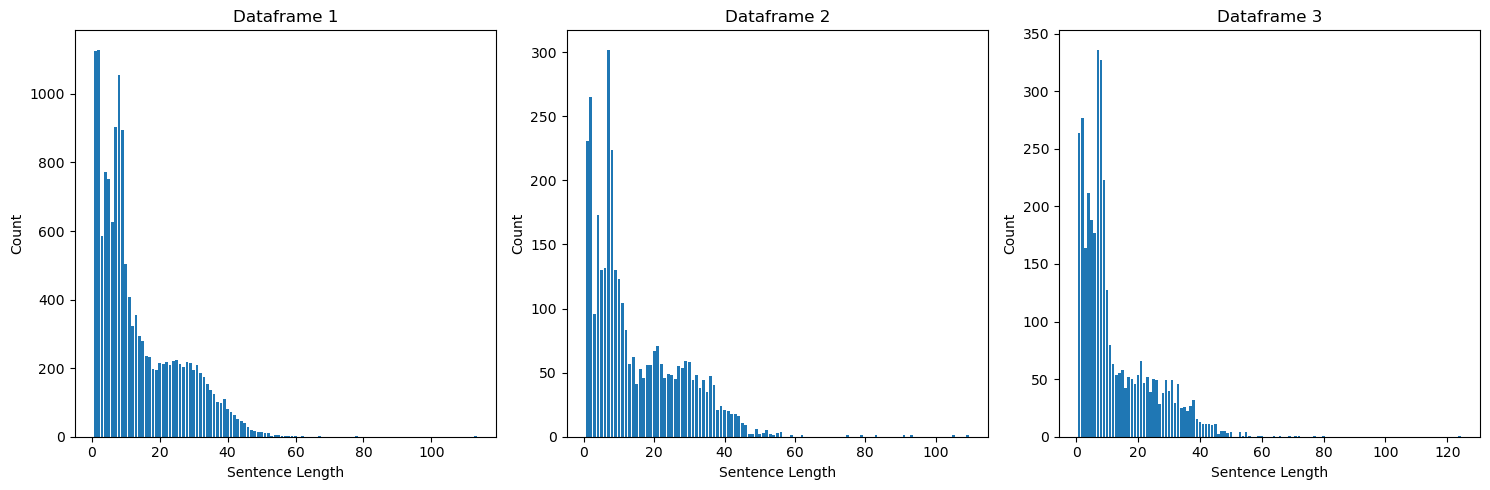

In [59]:
from collections import defaultdict
import matplotlib.pyplot as plt

def sentence_integrate(data):
    agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                 s["NEr tag"].values.tolist())]
    return data.groupby('Sentence Number').apply(agg_func).tolist()
  
train_df_sentences = sentence_integrate(train_df)
validation_df_sentences = sentence_integrate(validation_df)
test_df_sentences = sentence_integrate(test_df)

count_of_sentence_lengths = [defaultdict(int) for _ in range(3)]
for idx, data in enumerate([train_df_sentences, validation_df_sentences, test_df_sentences]):
    for s in data:
        count_of_sentence_lengths[idx][len(s)] += 1

# Create subplots for each dataframe
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms for each dataframe
for idx, count_dict in enumerate(count_of_sentence_lengths):
    lengths = list(count_dict.keys())
    counts = list(count_dict.values())
    
    axes[idx].bar(lengths, counts)
    axes[idx].set_title(f'Dataframe {idx + 1}')
    axes[idx].set_xlabel('Sentence Length')
    axes[idx].set_ylabel('Count')

print(f"""Max sentences for train_df={max(count_of_sentence_lengths[0])},
      validation_df={max(count_of_sentence_lengths[1])}, test_df={max(count_of_sentence_lengths[2])}""")
plt.tight_layout()
plt.show()

### Initialize Single LSTM model class and model helper functions

In [78]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class NERModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=0.2):
        super(NERModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)  # Freeze the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, num_labels)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x, random_initial_state=False):    
        embedded_x = self.embedding(x)
        
        if random_initial_state:
            h0 = torch.randn(1, embedded_x.size(0), self.hidden_dim).to(device)
            c0 = torch.randn(1, embedded_x.size(0), self.hidden_dim).to(device)
            lstm_out, _ = self.lstm(embedded_x, (h0, c0))
        else:
            lstm_out, _ = self.lstm(embedded_x)
            
        logits = self.linear(lstm_out)
        drop_out = self.dropout(logits)
        output = self.softmax(drop_out)
        return output

def get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings):
    return NERModel(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)
    
def save_model(model, name_="NERModel.pth"):
    torch.save(model.state_dict(), name_)
    return True

def load_model(model, name_="NERModel.pth"):
    loaded_model.load_state_dict(torch.load('model.pth'))
    return True

### Initialize data helper class functions

In [95]:
def preprocess_data(df, w2v_model, ner_label_mapping, max_sequence_length):
    ''' Convert df data to useful data to be trained and test on.
    Returns:
        sequences: tensor([][int]), stores word_to_idx sequence data.
        labels: tensor([][int]), stores index mapping of NER tagging.
        actual_sentence_len: LongTensor([int]), stores the actual sequence length, before paddings.
    '''
    sequences, labels, actual_sentence_len  = [], [], []
    
    # Process each sentence
    for sentence_number, sentence_data in df.groupby('Sentence Number'):
        # Tokenize the sentence
        sentence_tokens = sentence_data['Word'].values.tolist()
        ner_tags = sentence_data['NEr tag'].values.tolist()
        
        # Store the actual length of the sentence
        actual_sentence_len.append(len(sentence_tokens))
        
        # Create numerical labels for NER tags
        numerical_labels = [ner_label_mapping.get(tag, ner_label_mapping['O']) for tag in ner_tags]

        # Pad for every sequence less than the max_sequence_length
        if len(sentence_tokens) < max_sequence_length:
            num_tokens = len(sentence_tokens)
            num_padding = max_sequence_length - num_tokens
            sentence_tokens += ["<PADDED>"] * num_padding
            numerical_labels += [ner_label_mapping['O']] * num_padding
        assert len(sentence_tokens) == len(numerical_labels) == max_sequence_length
        if '</s>' in sentence_tokens: print(sentence_tokens)
        word_vectors = [w2v.index_to_key.index(token) if token in w2v_model else 3000000 for token in sentence_tokens]    
        sequences.append(word_vectors)
        labels.append(numerical_labels)
    return  torch.tensor(sequences), torch.tensor(labels, dtype=torch.long), torch.LongTensor(actual_sentence_len)

from torch.utils.data import DataLoader, TensorDataset
def get_training_data(batch_size, ner_label_mapping):
    ''' packs datas with data_loader.
    Returns train and validation data loaders, as well as their data actual lengths
    '''
    X_train, y_train, train_sentence_len = preprocess_data(train_df, w2v, ner_label_mapping, train_max_len)
    train_dataset = NERDataset(X_train, y_train)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(random_seed))

    X_validation, y_validation, validation_sentence_len = preprocess_data(validation_df, w2v, ner_label_mapping, val_max_len)
    validation_dataset = NERDataset(X_validation, y_validation)
    validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(random_seed))
    
    return train_data_loader, validation_data_loader, train_sentence_len, validation_sentence_len

def get_test_data(batch_size, ner_label_mapping):
    ''' packs datas with data_loader.
    Returns test data loaders, as well as their data actual lengths. 
    It is integrated seperately for easier maintainability and readability.
    '''
    X_test, y_test, test_sentence_len = preprocess_data(test_df, w2v, ner_label_mapping, test_max_len)
    test_dataset = NERDataset(X_test, y_test)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(random_seed))
    
    return test_data_loader, test_sentence_len

# Using Early stopper to stop when the F1Score prediction drops 
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_f1_score_ = 0

    def early_stop(self, f1_score_):
        if f1_score_ > self.min_f1_score_:
            self.min_f1_score_ = f1_score_
            self.counter = 0
        elif f1_score_ < (self.min_f1_score_ + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def plot_findings(X_axis:list, Y_axis:list, X_label:str, Y_labels:list = ["F1 Score", "Accuracy", "Time Taken (Seconds)"], isoptimal=False):
    ''' highly specific customized utility function for plotting results obtained, toggle state[isoptimal] between findings/optimal result.
    Parameters:
        X_axis: put length of "Batch_size" / "Epoch" here
        Y_axis: measurement parameters: [f1_score, accuracy, time] / 
                [[train_accuracies, val_accuracies], [train_losses, val_losses], [f1_score_arr]]
        X_label: put label of "Batch Size" / "Epoch" here
        Y_label: Optional, default: [f1_score, accuracy, time]
        isoptimal: Bool 
    '''
    # Create a line chart for accuracy with the exact X values
    plt.figure(figsize=(10, 4))
    color = ['r','g','b']
    optimal_labels = [["Train_accuracy","Validation_accuracy"], ["Train_losses", "Validation_losses"], ["F1_score"]]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        if not isoptimal:
            plt.plot(range(len(X_axis)), Y_axis[i], marker='o', linestyle='-', color=color[i], label=Y_labels[i])
            plt.xticks(range(len(X_axis)), X_axis)
        else:
            plt.plot(range(1, X_axis+1), Y_axis[i][0], color='r', label=optimal_labels[i][0])
            if i != 2: plt.plot(range(1, X_axis+1), Y_axis[i][1], color='g', label=optimal_labels[i][1])
            Y_labels = ["accuracy", "losses", "F1 score"]
        plt.xlabel(X_label)
        plt.ylabel(Y_labels[i])
        plt.title(f'{Y_labels[i]} vs. {X_label}')
        plt.grid(True)
        plt.legend()
        
    plt.tight_layout()
    plt.grid(True)
    print("Plot findings of training data")
    plt.show()
    
def get_device():
    if torch.cuda.is_available(): print("GPU Activated!")
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initialize train and test model functions

In [96]:
def train_model(model, train_data_loader, validation_data_loader, validation_sentence_len, device, epochs=50, 
                weights=None, early_stopper=None, random_initial_state=False, debug=True):
    # Define empty arrays to store train and test accuracies and losses, as well as F1 scores
    train_accuracies, validation_accuracies = [], []
    train_losses, validation_losses = [], []
    f1_score_arr = []
    
    # Define loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss(weight=weights)
    model = model.to(device)
    
    # Record the start time
    start_time = time.time()
    
    # Training loop
    for epoch in tqdm.tqdm(range(epochs)):
        # Record each epoch start time
        epoch_start_time = time.time()
    #=======================Training=======================
        model.train()
        train_loss = 0.0
        total_train, correct_train = 0, 0
        for idx, batch in enumerate(train_data_loader):
            batch_data, batch_labels = batch
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Train one step per batch data
            optimizer.zero_grad()
            outputs = model(batch_data, random_initial_state)
            loss = loss_fn(outputs.view(-1, 8), batch_labels.view(-1))
            loss.backward()
            optimizer.step()
            
            # Calculate train accuracy and loss
            train_loss += loss.item()
            predicted = torch.argmax(outputs, dim=2)
            total_train += batch_labels.size(0) * batch_labels.size(1)
            correct_train += (predicted == batch_labels).sum().item()
            del batch_data, batch_labels
        
        # Store accuracies and loss
        train_accuracies.append(correct_train / total_train)
        train_losses.append(train_loss / len(train_data_loader))

    #=======================Validation=======================
        model.eval()
        val_loss = 0.0
        correct_validation, total_validation = 0, 0
        
        # Reinitialize F1 scores variables
        true_labels, predicted_labels = [], []
        
        # Validate the current model's performance
        with torch.no_grad():
            for batch_data, batch_labels in validation_data_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

                outputs = model(batch_data)
                loss = loss_fn(outputs.view(-1, 8), batch_labels.view(-1))

                # Calculate test accuracy and loss
                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=2)
                total_validation += batch_labels.size(0) * batch_labels.size(1)
                correct_validation += (predicted == batch_labels).sum().item()
                true_labels.extend(batch_labels.cpu().numpy())  # Store true labels
                predicted_labels.extend(predicted.cpu().numpy())  # Store predicted labels
        
        # Store accuracies and loss
        validation_accuracies.append(correct_validation / total_validation)
        validation_losses.append(val_loss / len(validation_data_loader))
        
        # Calculate F1_score using seqeval.metrics, removing the padded O's to test on only the actual sentence
        y_pred_number = [data[:validation_sentence_len[idx]] for idx,data in enumerate(predicted_labels)]
        y_pred_tags = [[ner_labels[i] for i in word] for word in y_pred_number]
        y_true_number = [data[:validation_sentence_len[idx]] for idx,data in enumerate(true_labels)]
        y_true_tags = [[ner_labels[i] for i in word] for word in y_true_number]
    
        # Reinitializing seqeval to keep constant, tabulate F1 score
        from seqeval.metrics import f1_score
        latest_f1_score = f1_score(y_true_tags, y_pred_tags)
        f1_score_arr.append(latest_f1_score)

        # Print epoch results, if debug==True
        if debug:
            print("Epoch {:.2f}, F1 Score: {:.4f}, Time taken for this epoch: {:.2f}s.\n \
            Train Loss: {:.4f}, Val Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}.".format(
                    (epoch + 1),
                    f1_score_arr[-1],
                    time.time() - epoch_start_time,
                    train_losses[-1],
                    validation_losses[-1],
                    train_accuracies[-1],
                    validation_accuracies[-1]
                ))
        
        # Check for early stopping, if any
        if early_stopper:
            if early_stopper.early_stop(latest_f1_score):
                print(f"Early stopping at epoch ({epoch+1}) due to no improvement in f1 score.")
                break
    
    # Measure the total time taken for training of model
    time_taken = time.time() - start_time
    print(f"Time taken for the model to run finish: {time_taken:.2f} seconds")
    if device.type == 'cuda': torch.cuda.empty_cache() # Release cache
    return train_accuracies, validation_accuracies, train_losses, validation_losses, f1_score_arr, time_taken

def test_model(model, test_data_loader, test_sentence_len, device):
    model = model.to(device)
    model.eval()
    # Variables to track accuracy
    correct_test, total_test = 0 ,0
        
    # Define F1 scores variables
    true_labels, predicted_labels = [], []
    
    # Record the start time
    start_time = time.time()
    #=======================Testing=======================
    with torch.no_grad():
        for batch_data, batch_labels in test_data_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Predict each batch data
            outputs = model(batch_data)
            
            # Calculate and store test data
            predicted = torch.argmax(outputs, dim=2)
            total_test += batch_labels.size(0) * batch_labels.size(1)
            correct_test += (predicted == batch_labels).sum().item()
            
            # Store true and predicted labels
            true_labels.extend(batch_labels.cpu().numpy()) 
            predicted_labels.extend(predicted.cpu().numpy())
    
    # Set time taken for test
    time_taken = time.time() - start_time
    
    # Calculate F1_score using seqeval.metrics, removing the padded O's to test on only the actual sentence
    y_pred_number = [data[:test_sentence_len[idx]] for idx,data in enumerate(predicted_labels)]
    y_pred_tags = [[ner_labels[i] for i in word] for word in y_pred_number]
    y_true_number = [data[:test_sentence_len[idx]] for idx,data in enumerate(true_labels)]
    y_true_tags = [[ner_labels[i] for i in word] for word in y_true_number]

    # Reinitializing seqeval to keep constant, tabulate F1 score
    from seqeval.metrics import f1_score
    latest_f1_score = f1_score(y_true_tags, y_pred_tags)

    test_accuracy = correct_test / total_test
    print("Results of test model:")
    print(f"Time taken to run finish: {time_taken:.2f} seconds")
    print(f"F1 score: {latest_f1_score:.4f}, Test Accuracy: {test_accuracy:.4f}")
    if device.type == 'cuda': torch.cuda.empty_cache() # Release cache
    return test_accuracy, latest_f1_score, y_true_tags, y_pred_tags

### Initialize hyperparameters of models

In [93]:
random_seed = 42
ner_labels = ['B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'B-ORG', 'I-ORG', 'I-PER', 'O']
ner_label_mapping = {'B-LOC': 0, 'I-LOC': 1, 'B-MISC': 2, 'I-MISC': 3, 'B-ORG': 4, 'I-ORG': 5, 'I-PER': 6, 'O': 7}
embedding_dim = w2v.vector_size # 300 word vector representation of each word.
num_labels = len(ner_labels)
pretrained_embeddings = torch.FloatTensor(np.append(w2v.vectors, [np.zeros((300,))], axis=0)) # Appending a zero vector to handle unknown words to prevent 'x' out of range
train_max_len = max(count_of_sentence_lengths[0])
val_max_len = max(count_of_sentence_lengths[1])
test_max_len = max(count_of_sentence_lengths[2])
device = get_device()
# e_weights = 10
# weights = torch.tensor([e_weights, e_weights, e_weights, e_weights, e_weights, e_weights, e_weights, -10])

GPU Activated!


---
## Findings of using single LSTM layer

  2%|█▋                                                                                 | 1/50 [00:05<04:43,  5.78s/it]

Epoch 1.00, F1 Score: 0.0817, Time taken for this epoch: 5.78s.
             Train Loss: 1.3929, Val Loss: 1.2970, Train Accuracy: 0.8219, Validation Accuracy: 0.9777.


  4%|███▎                                                                               | 2/50 [00:11<04:35,  5.75s/it]

Epoch 2.00, F1 Score: 0.3188, Time taken for this epoch: 5.72s.
             Train Loss: 1.3790, Val Loss: 1.2946, Train Accuracy: 0.8264, Validation Accuracy: 0.9801.


  6%|████▉                                                                              | 3/50 [00:17<04:31,  5.78s/it]

Epoch 3.00, F1 Score: 0.6737, Time taken for this epoch: 5.83s.
             Train Loss: 1.3724, Val Loss: 1.2819, Train Accuracy: 0.8329, Validation Accuracy: 0.9922.


  8%|██████▋                                                                            | 4/50 [00:22<04:23,  5.72s/it]

Epoch 4.00, F1 Score: 0.7108, Time taken for this epoch: 5.63s.
             Train Loss: 1.3678, Val Loss: 1.2807, Train Accuracy: 0.8370, Validation Accuracy: 0.9933.


 10%|████████▎                                                                          | 5/50 [00:28<04:15,  5.68s/it]

Epoch 5.00, F1 Score: 0.7156, Time taken for this epoch: 5.61s.
             Train Loss: 1.3669, Val Loss: 1.2805, Train Accuracy: 0.8379, Validation Accuracy: 0.9935.


 12%|█████████▉                                                                         | 6/50 [00:34<04:09,  5.66s/it]

Epoch 6.00, F1 Score: 0.7267, Time taken for this epoch: 5.62s.
             Train Loss: 1.3667, Val Loss: 1.2804, Train Accuracy: 0.8381, Validation Accuracy: 0.9936.


 14%|███████████▌                                                                       | 7/50 [00:39<04:04,  5.68s/it]

Epoch 7.00, F1 Score: 0.7296, Time taken for this epoch: 5.71s.
             Train Loss: 1.3666, Val Loss: 1.2804, Train Accuracy: 0.8382, Validation Accuracy: 0.9936.


 16%|█████████████▎                                                                     | 8/50 [00:45<03:58,  5.67s/it]

Epoch 8.00, F1 Score: 0.7343, Time taken for this epoch: 5.65s.
             Train Loss: 1.3667, Val Loss: 1.2802, Train Accuracy: 0.8380, Validation Accuracy: 0.9938.


 18%|██████████████▉                                                                    | 9/50 [00:51<03:53,  5.69s/it]

Epoch 9.00, F1 Score: 0.7357, Time taken for this epoch: 5.74s.
             Train Loss: 1.3665, Val Loss: 1.2803, Train Accuracy: 0.8379, Validation Accuracy: 0.9936.


 20%|████████████████▍                                                                 | 10/50 [00:57<03:50,  5.75s/it]

Epoch 10.00, F1 Score: 0.7335, Time taken for this epoch: 5.90s.
             Train Loss: 1.3662, Val Loss: 1.2803, Train Accuracy: 0.8384, Validation Accuracy: 0.9938.


 22%|██████████████████                                                                | 11/50 [01:03<03:46,  5.82s/it]

Epoch 11.00, F1 Score: 0.7297, Time taken for this epoch: 5.96s.
             Train Loss: 1.3662, Val Loss: 1.2802, Train Accuracy: 0.8387, Validation Accuracy: 0.9938.


 24%|███████████████████▋                                                              | 12/50 [01:09<03:41,  5.83s/it]

Epoch 12.00, F1 Score: 0.7409, Time taken for this epoch: 5.86s.
             Train Loss: 1.3658, Val Loss: 1.2800, Train Accuracy: 0.8391, Validation Accuracy: 0.9939.


 26%|█████████████████████▎                                                            | 13/50 [01:14<03:36,  5.86s/it]

Epoch 13.00, F1 Score: 0.7402, Time taken for this epoch: 5.93s.
             Train Loss: 1.3662, Val Loss: 1.2800, Train Accuracy: 0.8384, Validation Accuracy: 0.9939.


 28%|██████████████████████▉                                                           | 14/50 [01:20<03:31,  5.87s/it]

Epoch 14.00, F1 Score: 0.7313, Time taken for this epoch: 5.90s.
             Train Loss: 1.3662, Val Loss: 1.2800, Train Accuracy: 0.8384, Validation Accuracy: 0.9939.


 30%|████████████████████████▌                                                         | 15/50 [01:26<03:24,  5.86s/it]

Epoch 15.00, F1 Score: 0.7413, Time taken for this epoch: 5.82s.
             Train Loss: 1.3661, Val Loss: 1.2799, Train Accuracy: 0.8386, Validation Accuracy: 0.9939.


 32%|██████████████████████████▏                                                       | 16/50 [01:32<03:16,  5.79s/it]

Epoch 16.00, F1 Score: 0.7392, Time taken for this epoch: 5.63s.
             Train Loss: 1.3658, Val Loss: 1.2800, Train Accuracy: 0.8390, Validation Accuracy: 0.9939.


 34%|███████████████████████████▉                                                      | 17/50 [01:37<03:09,  5.76s/it]

Epoch 17.00, F1 Score: 0.7384, Time taken for this epoch: 5.68s.
             Train Loss: 1.3659, Val Loss: 1.2801, Train Accuracy: 0.8388, Validation Accuracy: 0.9939.


 36%|█████████████████████████████▌                                                    | 18/50 [01:43<03:03,  5.73s/it]

Epoch 18.00, F1 Score: 0.7438, Time taken for this epoch: 5.68s.
             Train Loss: 1.3659, Val Loss: 1.2799, Train Accuracy: 0.8388, Validation Accuracy: 0.9940.


 38%|███████████████████████████████▏                                                  | 19/50 [01:49<02:58,  5.75s/it]

Epoch 19.00, F1 Score: 0.7417, Time taken for this epoch: 5.78s.
             Train Loss: 1.3660, Val Loss: 1.2800, Train Accuracy: 0.8386, Validation Accuracy: 0.9940.


 40%|████████████████████████████████▊                                                 | 20/50 [01:55<02:52,  5.75s/it]

Epoch 20.00, F1 Score: 0.7341, Time taken for this epoch: 5.77s.
             Train Loss: 1.3656, Val Loss: 1.2800, Train Accuracy: 0.8391, Validation Accuracy: 0.9939.


 42%|██████████████████████████████████▍                                               | 21/50 [02:00<02:47,  5.76s/it]

Epoch 21.00, F1 Score: 0.7467, Time taken for this epoch: 5.77s.
             Train Loss: 1.3660, Val Loss: 1.2799, Train Accuracy: 0.8388, Validation Accuracy: 0.9940.


 44%|████████████████████████████████████                                              | 22/50 [02:06<02:40,  5.75s/it]

Epoch 22.00, F1 Score: 0.7438, Time taken for this epoch: 5.72s.
             Train Loss: 1.3659, Val Loss: 1.2798, Train Accuracy: 0.8386, Validation Accuracy: 0.9940.


 46%|█████████████████████████████████████▋                                            | 23/50 [02:12<02:35,  5.75s/it]

Epoch 23.00, F1 Score: 0.7587, Time taken for this epoch: 5.75s.
             Train Loss: 1.3651, Val Loss: 1.2800, Train Accuracy: 0.8401, Validation Accuracy: 0.9941.


 48%|███████████████████████████████████████▎                                          | 24/50 [02:18<02:29,  5.75s/it]

Epoch 24.00, F1 Score: 0.7545, Time taken for this epoch: 5.75s.
             Train Loss: 1.3655, Val Loss: 1.2799, Train Accuracy: 0.8392, Validation Accuracy: 0.9941.


 50%|█████████████████████████████████████████                                         | 25/50 [02:24<02:24,  5.80s/it]

Epoch 25.00, F1 Score: 0.7522, Time taken for this epoch: 5.90s.
             Train Loss: 1.3654, Val Loss: 1.2799, Train Accuracy: 0.8394, Validation Accuracy: 0.9941.


 50%|█████████████████████████████████████████                                         | 25/50 [02:29<02:29,  5.99s/it]

Epoch 26.00, F1 Score: 0.7494, Time taken for this epoch: 5.72s.
             Train Loss: 1.3654, Val Loss: 1.2799, Train Accuracy: 0.8395, Validation Accuracy: 0.9941.
Early stopping at epoch (26) due to no improvement in f1 score.
Time taken for the model to run finish: 149.82 seconds


Results of test model:
Time taken to run finish: 0.53 seconds
F1 score: 0.7188, Test Accuracy: 0.9950
Plot findings of training data


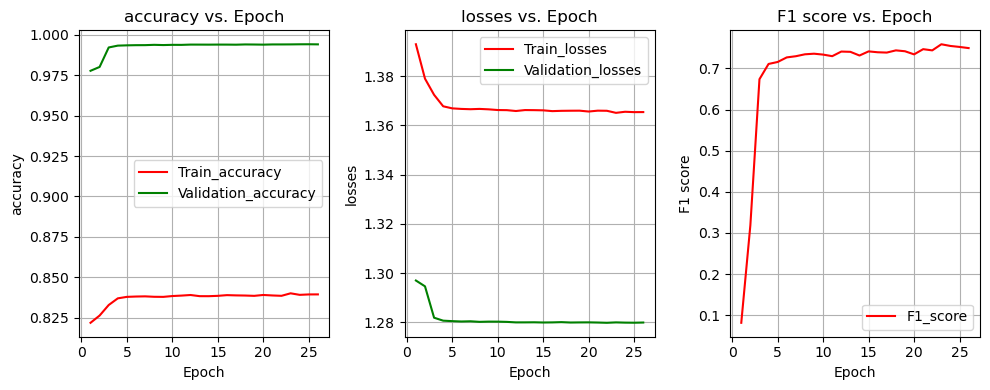

In [100]:
if device.type == 'cuda': torch.cuda.empty_cache() # Release cache

# OPTIMAL parameter found for single LSTM layer
batch_size = 64
hidden_dim = 512
epoch = 50

# Get dataset loaders
train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(batch_size, ner_label_mapping)
test_data_loader, test_sentence_len = get_test_data(batch_size, ner_label_mapping)

# Initialize EarlyStopper and model
early_stopper = EarlyStopper(patience=3)
model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)

# Train the model
train_accuracies, val_accuracies, train_losses, val_losses, f1_score_arr, time_taken = train_model(model, train_data_loader, 
    val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=True)

# Test the model
test_accuracy, f1_score, y_true_tags, y_pred_tags = test_model(model, test_data_loader, test_sentence_len, device)

# Plot findings
plot_findings(len(train_accuracies), [[train_accuracies, val_accuracies], [train_losses, val_losses], [f1_score_arr]], "Epoch", isoptimal=True)

# If want to save model:
# save_model(model)

### Findings for the optimal single lstm layer parameters for hidden_dim and batch size

 50%|█████████████████████████████████████████                                         | 25/50 [02:04<02:04,  4.98s/it]

Early stopping at epoch (26) due to no improvement in f1 score.
Time taken for the model to run finish: 124.40 seconds


Time taken to run finish: 0.56 seconds
F1 score: 0.7121, Test Accuracy: 0.9948


 44%|████████████████████████████████████                                              | 22/50 [01:35<02:01,  4.32s/it]

Early stopping at epoch (23) due to no improvement in f1 score.
Time taken for the model to run finish: 95.12 seconds


Time taken to run finish: 0.42 seconds
F1 score: 0.7650, Test Accuracy: 0.9959


 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:42<01:14,  3.53s/it]

Early stopping at epoch (30) due to no improvement in f1 score.
Time taken for the model to run finish: 102.36 seconds


Time taken to run finish: 0.34 seconds
F1 score: 0.7620, Test Accuracy: 0.9959


 50%|█████████████████████████████████████████                                         | 25/50 [01:24<01:24,  3.36s/it]

Early stopping at epoch (26) due to no improvement in f1 score.
Time taken for the model to run finish: 84.06 seconds


Time taken to run finish: 0.35 seconds
F1 score: 0.7144, Test Accuracy: 0.9949


 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:37<00:59,  3.13s/it]

Early stopping at epoch (32) due to no improvement in f1 score.
Time taken for the model to run finish: 97.06 seconds


Time taken to run finish: 0.31 seconds
F1 score: 0.7052, Test Accuracy: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:35<00:00,  3.10s/it]


Time taken for the model to run finish: 155.17 seconds
Time taken to run finish: 0.31 seconds
F1 score: 0.6973, Test Accuracy: 0.9946


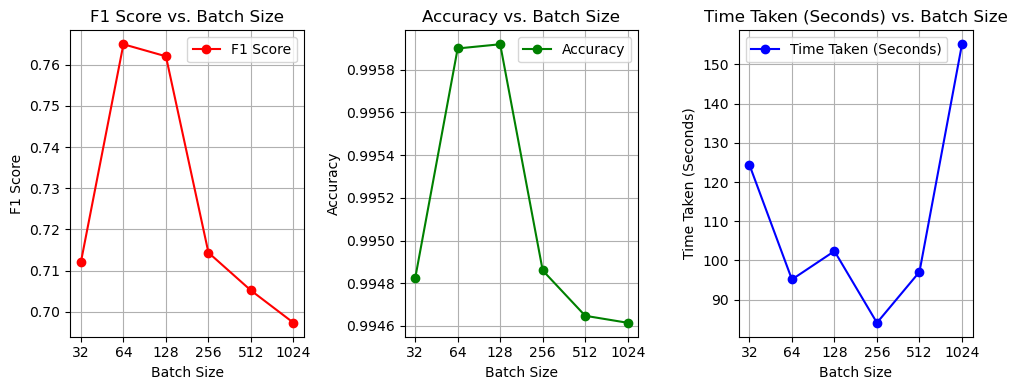

Best f1_score for Batch Size: 64, 0.7649696649960434


In [27]:
# Test for optimal batch size using 512 hidden_dim obtained below

if device.type == 'cuda': torch.cuda.empty_cache() # Release cache

# Fixed parameters for this testing
epoch = 50
hidden_dim = 512

# Variable for testing
batch_size = [32,64,128,256,512,1024]
F1_s, acc, tt = [], [], []
for BS in batch_size:
    # Get dataset loaders with different batch size
    train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(BS)
    test_data_loader, test_sentence_len = get_test_data(BS)
    
    # Initialize EarlyStopper and model
    early_stopper = EarlyStopper(patience=3)
    model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)
    
    # Train and test the model on the parameters set
    _,_,_,_, f1_score_arr, time_taken = train_model(model, train_data_loader, val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=False)
    test_accuracy, f1_score, _,_ = test_model(model, test_data_loader, test_sentence_len, device)
    F1_s.append(f1_score)
    acc.append(test_accuracy)
    tt.append(time_taken)

# Report findings
plot_findings(batch_size, [F1_s,acc,tt], "Batch Size")
print(f"Best f1_score for Batch Size: {batch_size[F1_s.index(max(F1_s))]}, {max(F1_s)}")

 54%|████████████████████████████████████████████▎                                     | 27/50 [00:31<00:26,  1.15s/it]

Early stopping at epoch (28) due to no improvement in f1 score.
Time taken for the model to run finish: 31.12 seconds


Time taken to run finish: 0.10 seconds
F1 score: 0.7550, Test Accuracy: 0.9956


 50%|█████████████████████████████████████████                                         | 25/50 [00:29<00:29,  1.20s/it]

Early stopping at epoch (26) due to no improvement in f1 score.
Time taken for the model to run finish: 29.94 seconds
Time taken to run finish: 0.09 seconds
F1 score: 0.7599, Test Accuracy: 0.9959



 36%|█████████████████████████████▌                                                    | 18/50 [00:23<00:42,  1.32s/it]

Early stopping at epoch (19) due to no improvement in f1 score.
Time taken for the model to run finish: 23.72 seconds
Time taken to run finish: 0.11 seconds
F1 score: 0.7481, Test Accuracy: 0.9959



 30%|████████████████████████▌                                                         | 15/50 [00:32<01:14,  2.14s/it]

Early stopping at epoch (16) due to no improvement in f1 score.
Time taken for the model to run finish: 32.04 seconds


Time taken to run finish: 0.29 seconds
F1 score: 0.7179, Test Accuracy: 0.9949


 30%|████████████████████████▌                                                         | 15/50 [01:02<02:26,  4.20s/it]

Early stopping at epoch (16) due to no improvement in f1 score.
Time taken for the model to run finish: 62.95 seconds


Time taken to run finish: 0.39 seconds
F1 score: 0.7202, Test Accuracy: 0.9949


 48%|███████████████████████████████████████▎                                          | 24/50 [02:10<02:21,  5.43s/it]

Early stopping at epoch (25) due to no improvement in f1 score.
Time taken for the model to run finish: 130.21 seconds


Time taken to run finish: 0.56 seconds
F1 score: 0.7639, Test Accuracy: 0.9960


 38%|███████████████████████████████▏                                                  | 19/50 [04:08<06:45, 13.07s/it]

Early stopping at epoch (20) due to no improvement in f1 score.
Time taken for the model to run finish: 248.26 seconds


Time taken to run finish: 1.33 seconds
F1 score: 0.7629, Test Accuracy: 0.9960


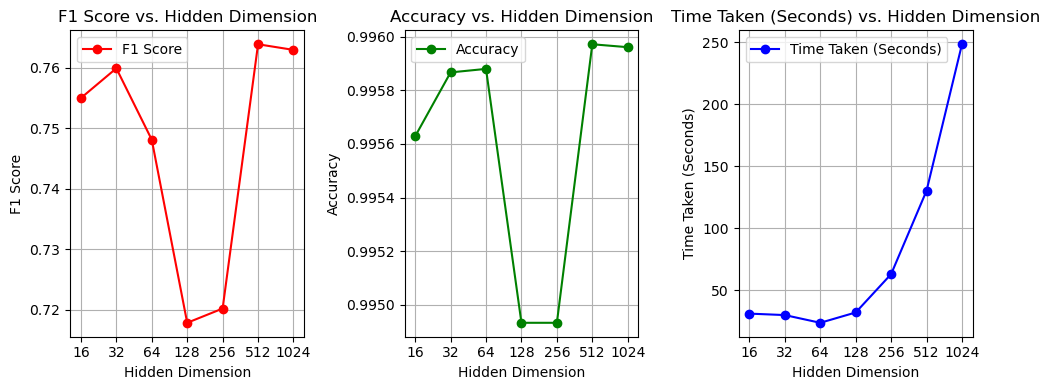

Best f1_score for Hidden Dim: 512, 0.7638614513367574


In [28]:
# Test for optimal hidden_dim using 32 batchsize obtained above

if device.type == 'cuda': torch.cuda.empty_cache() # Release cache

# Fixed parameters for this testing
epoch = 50
batch_size = 32

# Get dataset loaders with fixed batch size
train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(batch_size, ner_label_mapping)
test_data_loader, test_sentence_len = get_test_data(batch_size, ner_label_mapping)

# Variable for testing
hidden_dim = [16,32,64,128,256,512,1024]
F1_s, acc, tt = [], [], []
for hd in hidden_dim:
    # Initialize EarlyStopper and model
    early_stopper = EarlyStopper(patience=3)
    model = get_model(embedding_dim, hd, num_labels, pretrained_embeddings)
    
    # Train and test the model on the parameters set
    _,_,_,_, f1_score_arr, time_taken = train_model(model, train_data_loader, val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=False)
    test_accuracy, f1_score, _,_ = test_model(model, test_data_loader, test_sentence_len, device)
    F1_s.append(f1_score)
    acc.append(test_accuracy)
    tt.append(time_taken)

# Report findings
plot_findings(hidden_dim, [F1_s,acc,tt], "Hidden Dimension")
print(f"Best f1_score for Hidden Dim: {hidden_dim[F1_s.index(max(F1_s))]}, {max(F1_s)}")

 50%|█████████████████████████████████████████                                         | 25/50 [00:19<00:19,  1.29it/s]

Early stopping at epoch (26) due to no improvement in f1 score.
Time taken for the model to run finish: 19.37 seconds
Time taken to run finish: 0.10 seconds
F1 score: 0.6748, Test Accuracy: 0.9943



 50%|█████████████████████████████████████████                                         | 25/50 [00:21<00:21,  1.14it/s]

Early stopping at epoch (26) due to no improvement in f1 score.
Time taken for the model to run finish: 21.89 seconds
Time taken to run finish: 0.12 seconds
F1 score: 0.7442, Test Accuracy: 0.9956



 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:32<00:19,  1.05s/it]

Early stopping at epoch (32) due to no improvement in f1 score.
Time taken for the model to run finish: 32.46 seconds


Time taken to run finish: 0.15 seconds
F1 score: 0.7561, Test Accuracy: 0.9960


 52%|██████████████████████████████████████████▋                                       | 26/50 [00:47<00:44,  1.84s/it]

Early stopping at epoch (27) due to no improvement in f1 score.
Time taken for the model to run finish: 47.74 seconds


Time taken to run finish: 0.24 seconds
F1 score: 0.7547, Test Accuracy: 0.9959


 34%|███████████████████████████▉                                                      | 17/50 [00:43<01:24,  2.57s/it]

Early stopping at epoch (18) due to no improvement in f1 score.
Time taken for the model to run finish: 43.63 seconds


Time taken to run finish: 0.27 seconds
F1 score: 0.7127, Test Accuracy: 0.9949


 48%|███████████████████████████████████████▎                                          | 24/50 [01:44<01:53,  4.37s/it]

Early stopping at epoch (25) due to no improvement in f1 score.
Time taken for the model to run finish: 104.90 seconds


Time taken to run finish: 0.42 seconds
F1 score: 0.7693, Test Accuracy: 0.9961


 38%|███████████████████████████████▏                                                  | 19/50 [02:45<04:29,  8.70s/it]

Early stopping at epoch (20) due to no improvement in f1 score.
Time taken for the model to run finish: 165.22 seconds


Time taken to run finish: 0.79 seconds
F1 score: 0.7573, Test Accuracy: 0.9960


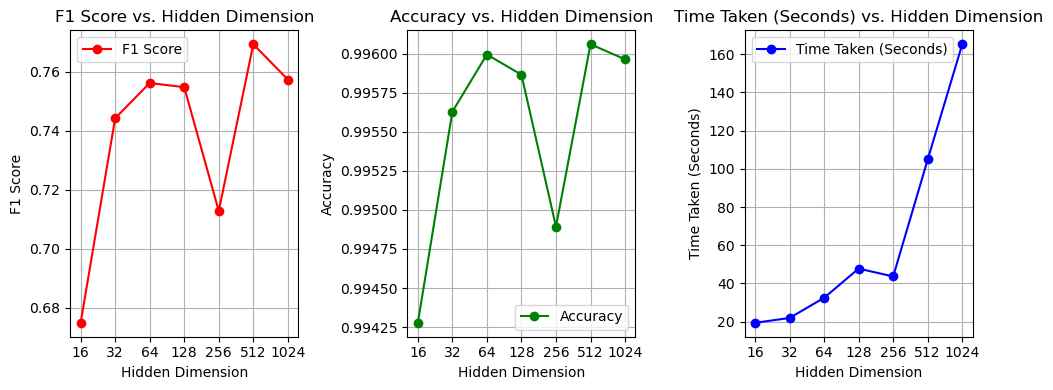

Best f1_score for Hidden Dim: 512, 0.7692511597084162


In [29]:
# Test for optimal hidden_dim using 64 batchsize obtained above

if device.type == 'cuda': torch.cuda.empty_cache() # Release cache

# Fixed parameters for this testing
epoch = 50
batch_size = 64

# Get dataset loaders with fixed batch size
train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(batch_size, ner_label_mapping)
test_data_loader, test_sentence_len = get_test_data(batch_size, ner_label_mapping)

# Variable for testing
hidden_dim = [16,32,64,128,256,512,1024] 
F1_s, acc, tt = [], [], []
for hd in hidden_dim:
    # Initialize EarlyStopper and model
    early_stopper = EarlyStopper(patience=3)
    model = get_model(embedding_dim, hd, num_labels, pretrained_embeddings)
    
    # Train and test the model on the parameters set
    _,_,_,_, f1_score_arr, time_taken = train_model(model, train_data_loader, val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=False)
    test_accuracy, f1_score, _,_ = test_model(model, test_data_loader, test_sentence_len, device)
    F1_s.append(f1_score)
    acc.append(test_accuracy)
    tt.append(time_taken)

# Report findings
plot_findings(hidden_dim, [F1_s,acc,tt], "Hidden Dimension")
print(f"Best f1_score for Hidden Dim: {hidden_dim[F1_s.index(max(F1_s))]}, {max(F1_s)}")

---
## Findings of double stacked LSTM layer

  2%|█▋                                                                                 | 1/50 [00:05<04:18,  5.28s/it]

Epoch 1.00, F1 Score: 0.1245, Time taken for this epoch: 5.28s.
             Train Loss: 1.3912, Val Loss: 1.2963, Train Accuracy: 0.8234, Validation Accuracy: 0.9782.


  4%|███▎                                                                               | 2/50 [00:10<04:10,  5.23s/it]

Epoch 2.00, F1 Score: 0.5595, Time taken for this epoch: 5.19s.
             Train Loss: 1.3762, Val Loss: 1.2840, Train Accuracy: 0.8289, Validation Accuracy: 0.9904.


  6%|████▉                                                                              | 3/50 [00:15<04:03,  5.19s/it]

Epoch 3.00, F1 Score: 0.7063, Time taken for this epoch: 5.14s.
             Train Loss: 1.3684, Val Loss: 1.2809, Train Accuracy: 0.8367, Validation Accuracy: 0.9931.


  8%|██████▋                                                                            | 4/50 [00:20<03:58,  5.18s/it]

Epoch 4.00, F1 Score: 0.7195, Time taken for this epoch: 5.17s.
             Train Loss: 1.3673, Val Loss: 1.2805, Train Accuracy: 0.8374, Validation Accuracy: 0.9934.


 10%|████████▎                                                                          | 5/50 [00:25<03:53,  5.19s/it]

Epoch 5.00, F1 Score: 0.7227, Time taken for this epoch: 5.19s.
             Train Loss: 1.3670, Val Loss: 1.2804, Train Accuracy: 0.8376, Validation Accuracy: 0.9935.


 12%|█████████▉                                                                         | 6/50 [00:31<03:54,  5.34s/it]

Epoch 6.00, F1 Score: 0.7284, Time taken for this epoch: 5.64s.
             Train Loss: 1.3666, Val Loss: 1.2803, Train Accuracy: 0.8382, Validation Accuracy: 0.9937.


 14%|███████████▌                                                                       | 7/50 [00:36<03:49,  5.35s/it]

Epoch 7.00, F1 Score: 0.7284, Time taken for this epoch: 5.36s.
             Train Loss: 1.3665, Val Loss: 1.2803, Train Accuracy: 0.8382, Validation Accuracy: 0.9937.


 16%|█████████████▎                                                                     | 8/50 [00:42<03:44,  5.35s/it]

Epoch 8.00, F1 Score: 0.7288, Time taken for this epoch: 5.34s.
             Train Loss: 1.3663, Val Loss: 1.2802, Train Accuracy: 0.8386, Validation Accuracy: 0.9937.


 18%|██████████████▉                                                                    | 9/50 [00:47<03:39,  5.34s/it]

Epoch 9.00, F1 Score: 0.7338, Time taken for this epoch: 5.34s.
             Train Loss: 1.3659, Val Loss: 1.2801, Train Accuracy: 0.8389, Validation Accuracy: 0.9938.


 20%|████████████████▍                                                                 | 10/50 [00:53<03:35,  5.38s/it]

Epoch 10.00, F1 Score: 0.8091, Time taken for this epoch: 5.45s.
             Train Loss: 1.3663, Val Loss: 1.2786, Train Accuracy: 0.8383, Validation Accuracy: 0.9954.


 22%|██████████████████                                                                | 11/50 [00:58<03:29,  5.38s/it]

Epoch 11.00, F1 Score: 0.8156, Time taken for this epoch: 5.39s.
             Train Loss: 1.3649, Val Loss: 1.2783, Train Accuracy: 0.8399, Validation Accuracy: 0.9957.


 24%|███████████████████▋                                                              | 12/50 [01:03<03:24,  5.38s/it]

Epoch 12.00, F1 Score: 0.8182, Time taken for this epoch: 5.38s.
             Train Loss: 1.3649, Val Loss: 1.2782, Train Accuracy: 0.8399, Validation Accuracy: 0.9959.


 26%|█████████████████████▎                                                            | 13/50 [01:09<03:20,  5.42s/it]

Epoch 13.00, F1 Score: 0.8172, Time taken for this epoch: 5.52s.
             Train Loss: 1.3646, Val Loss: 1.2779, Train Accuracy: 0.8402, Validation Accuracy: 0.9961.


 28%|██████████████████████▉                                                           | 14/50 [01:14<03:14,  5.41s/it]

Epoch 14.00, F1 Score: 0.8306, Time taken for this epoch: 5.40s.
             Train Loss: 1.3646, Val Loss: 1.2779, Train Accuracy: 0.8400, Validation Accuracy: 0.9961.


 30%|████████████████████████▌                                                         | 15/50 [01:20<03:08,  5.38s/it]

Epoch 15.00, F1 Score: 0.8249, Time taken for this epoch: 5.29s.
             Train Loss: 1.3645, Val Loss: 1.2779, Train Accuracy: 0.8402, Validation Accuracy: 0.9961.


 32%|██████████████████████████▏                                                       | 16/50 [01:25<03:01,  5.35s/it]

Epoch 16.00, F1 Score: 0.8263, Time taken for this epoch: 5.28s.
             Train Loss: 1.3645, Val Loss: 1.2777, Train Accuracy: 0.8402, Validation Accuracy: 0.9962.


 32%|██████████████████████████▏                                                       | 16/50 [01:30<03:12,  5.67s/it]

Epoch 17.00, F1 Score: 0.8225, Time taken for this epoch: 5.34s.
             Train Loss: 1.3641, Val Loss: 1.2779, Train Accuracy: 0.8406, Validation Accuracy: 0.9962.
Early stopping at epoch (17) due to no improvement in f1 score.
Time taken for the model to run finish: 90.72 seconds


Time taken to run finish: 0.50 seconds
F1 score: 0.7603, Test Accuracy: 0.9958


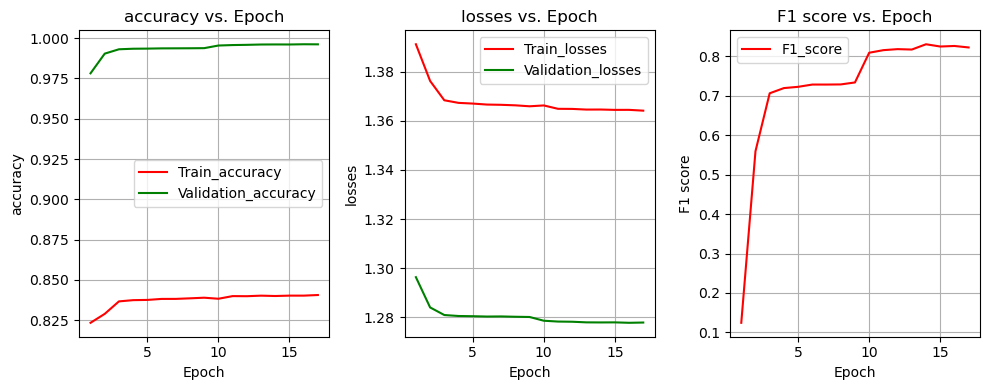

In [88]:
class NERModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=0.2):
        super(NERModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)  # Freeze the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, num_labels)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x, random_initial_state=False):    
        embedded_x = self.embedding(x)
        
        if random_initial_state:
            # Utilize random initial state
            h0 = torch.randn(1, embedded_x.size(0), self.hidden_dim).to(device)
            c0 = torch.randn(1, embedded_x.size(0), self.hidden_dim).to(device)
            lstm_out, (h_0,c_0) = self.lstm(embedded_x, (h0,c0))
            lstm2_out, _ = self.lstm2(lstm_out, (h_0,c_0))
        else:
            # Utilize Zero initial state
            lstm_out, _ = self.lstm(embedded_x)
            lstm2_out, _ = self.lstm2(lstm_out)
            
        logits = self.linear(lstm2_out)
        drop_out = self.dropout(logits)
        output = self.softmax(drop_out)
        return output

if device.type == 'cuda': torch.cuda.empty_cache() # Release cache

# OPTIMAL parameter found for double stacked LSTM layer
batch_size = 32
hidden_dim = 256
epoch = 50

# Get dataset loaders
train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(batch_size, ner_label_mapping)
test_data_loader, test_sentence_len = get_test_data(batch_size, ner_label_mapping)

# Initialize EarlyStopper and model
early_stopper = EarlyStopper(patience=3)
model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)

# Train the model
train_accuracies, val_accuracies, train_losses, val_losses, f1_score_arr, time_taken = train_model(model, train_data_loader, 
    val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=True)

# Test the model
test_accuracy, f1_score, y_true_tags, y_pred_tags = test_model(model, test_data_loader, test_sentence_len, device)

# Plot findings
plot_findings(len(train_accuracies), [[train_accuracies, val_accuracies], [train_losses, val_losses], [f1_score_arr]], "Epoch", isoptimal=True)

### Below are the findings of getting the "optimal" parameters for a double stacked LSTM layer

 24%|███████████████████▋                                                              | 12/50 [01:11<03:47,  5.97s/it]

Early stopping at epoch (13) due to no improvement in f1 score.
Time taken for the model to run finish: 71.69 seconds


Time taken to run finish: 0.47 seconds
F1 score: 0.7179, Test Accuracy: 0.9948


 24%|███████████████████▋                                                              | 12/50 [00:42<02:15,  3.57s/it]

Early stopping at epoch (13) due to no improvement in f1 score.
Time taken for the model to run finish: 42.81 seconds


Time taken to run finish: 0.31 seconds
F1 score: 0.7053, Test Accuracy: 0.9947


 44%|████████████████████████████████████                                              | 22/50 [00:49<01:02,  2.25s/it]

Early stopping at epoch (23) due to no improvement in f1 score.
Time taken for the model to run finish: 49.41 seconds


Time taken to run finish: 0.19 seconds
F1 score: 0.7020, Test Accuracy: 0.9947


 50%|█████████████████████████████████████████                                         | 25/50 [00:48<00:48,  1.94s/it]

Early stopping at epoch (26) due to no improvement in f1 score.
Time taken for the model to run finish: 48.48 seconds


Time taken to run finish: 0.16 seconds
F1 score: 0.6983, Test Accuracy: 0.9947


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:17<00:08,  1.73s/it]

Early stopping at epoch (46) due to no improvement in f1 score.
Time taken for the model to run finish: 77.98 seconds


Time taken to run finish: 0.17 seconds
F1 score: 0.7025, Test Accuracy: 0.9947


 32%|██████████████████████████▏                                                       | 16/50 [00:27<00:57,  1.70s/it]

Early stopping at epoch (17) due to no improvement in f1 score.
Time taken for the model to run finish: 27.20 seconds


Time taken to run finish: 0.16 seconds
F1 score: 0.0005, Test Accuracy: 0.9823


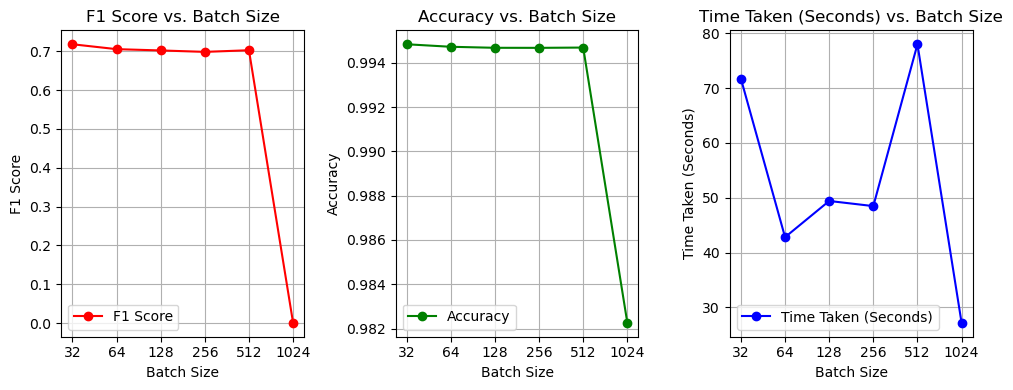

Best f1_score for Batch Size: 32, 0.7178938928237337


In [90]:
# Test for optimal batch size using hidden dimension of 512 obtained below

if device.type == 'cuda': torch.cuda.empty_cache() # Release cache
    
# Fixed parameters for this testing
epoch = 50
hidden_dim = 256

# Variable for testing
F1_s, acc, tt = [], [], []
batch_size = [32,64,128,256,512,1024]
for BS in batch_size:
    
    # Get dataset loaders with different batch size
    train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(BS, ner_label_mapping)
    test_data_loader, test_sentence_len = get_test_data(BS, ner_label_mapping)
    
    # Initialize EarlyStopper and model
    early_stopper = EarlyStopper(patience=3)
    model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)
    
    # Train and test the model on the parameters set
    _,_,_,_, f1_score_arr, time_taken = train_model(model, train_data_loader, val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=False)
    test_accuracy, f1_score, _,_ = test_model(model, test_data_loader, test_sentence_len, device)
    F1_s.append(f1_score)
    acc.append(test_accuracy)
    tt.append(time_taken)
    
# Report findings
plot_findings(batch_size, [F1_s,acc,tt], "Batch Size")
print(f"Best f1_score for Batch Size: {batch_size[F1_s.index(max(F1_s))]}, {max(F1_s)}")

 46%|█████████████████████████████████████▋                                            | 23/50 [00:29<00:34,  1.29s/it]

Early stopping at epoch (24) due to no improvement in f1 score.
Time taken for the model to run finish: 29.57 seconds
Time taken to run finish: 0.09 seconds
F1 score: 0.7206, Test Accuracy: 0.9947



 34%|███████████████████████████▉                                                      | 17/50 [00:21<00:42,  1.29s/it]

Early stopping at epoch (18) due to no improvement in f1 score.
Time taken for the model to run finish: 21.89 seconds
Time taken to run finish: 0.09 seconds
F1 score: 0.7167, Test Accuracy: 0.9948



 38%|███████████████████████████████▏                                                  | 19/50 [00:24<00:39,  1.28s/it]

Early stopping at epoch (20) due to no improvement in f1 score.
Time taken for the model to run finish: 24.31 seconds
Time taken to run finish: 0.12 seconds
F1 score: 0.7186, Test Accuracy: 0.9949



 42%|██████████████████████████████████▍                                               | 21/50 [00:38<00:53,  1.84s/it]

Early stopping at epoch (22) due to no improvement in f1 score.
Time taken for the model to run finish: 38.66 seconds


Time taken to run finish: 0.19 seconds
F1 score: 0.7590, Test Accuracy: 0.9958


 30%|████████████████████████▌                                                         | 15/50 [01:24<03:18,  5.66s/it]

Early stopping at epoch (16) due to no improvement in f1 score.
Time taken for the model to run finish: 84.96 seconds


Time taken to run finish: 0.50 seconds
F1 score: 0.7649, Test Accuracy: 0.9959


 38%|███████████████████████████████▏                                                  | 19/50 [02:39<04:19,  8.38s/it]

Early stopping at epoch (20) due to no improvement in f1 score.
Time taken for the model to run finish: 159.13 seconds


Time taken to run finish: 0.74 seconds
F1 score: 0.7200, Test Accuracy: 0.9949


 24%|███████████████████▋                                                              | 12/50 [04:56<15:38, 24.69s/it]

Early stopping at epoch (13) due to no improvement in f1 score.
Time taken for the model to run finish: 296.33 seconds


Time taken to run finish: 2.14 seconds
F1 score: 0.7122, Test Accuracy: 0.9948


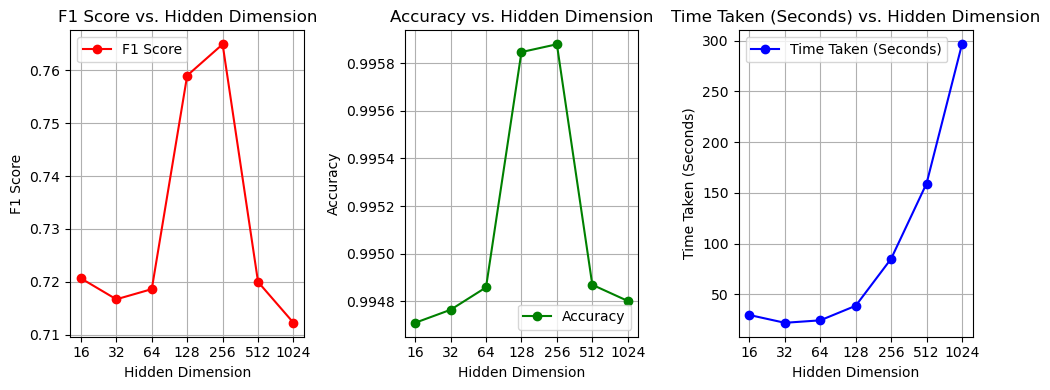

Best f1_score for Hidden Dim: 256, 0.7649433519989582


In [91]:
# Test for optimal hidden_dim using 32 batchsize obtained above

if device.type == 'cuda': torch.cuda.empty_cache() # Release cache

# Fixed parameters for this testing
epoch = 50
batch_size = 32

# Get dataset loaders with fixed batch size
train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(batch_size, ner_label_mapping)
test_data_loader, test_sentence_len = get_test_data(batch_size, ner_label_mapping)

# Variable for testing
hidden_dim = [16,32,64,128,256,512,1024] # Change to see if there are any improvements
F1_s, acc, tt = [], [], []
for hd in hidden_dim:
    # Initialize EarlyStopper and model
    early_stopper = EarlyStopper(patience=3)
    model = get_model(embedding_dim, hd, num_labels, pretrained_embeddings)
    
    # Train and test the model on the parameters set
    _,_,_,_, f1_score_arr, time_taken = train_model(model, train_data_loader, val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=False)
    test_accuracy, f1_score, _,_ = test_model(model, test_data_loader, test_sentence_len, device)
    F1_s.append(f1_score)
    acc.append(test_accuracy)
    tt.append(time_taken)
    
# Report findings
plot_findings(hidden_dim, [F1_s,acc,tt], "Hidden Dimension")
print(f"Best f1_score for Hidden Dim: {hidden_dim[F1_s.index(max(F1_s))]}, {max(F1_s)}")

---
## Using Multi-head self-attention!!

In [101]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, input_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert input_dim % num_heads == 0 # Ensure that the input_dim are divisable by num_heads
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads

        self.W_q = nn.ModuleList([nn.Linear(input_dim, self.head_dim) for _ in range(num_heads)])
        self.W_k = nn.ModuleList([nn.Linear(input_dim, self.head_dim) for _ in range(num_heads)])
        self.W_v = nn.ModuleList([nn.Linear(input_dim, self.head_dim) for _ in range(num_heads)])
        self.W_o = nn.Linear(input_dim, input_dim)

    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        head_outputs = []

        for i in range(self.num_heads):
            q = self.W_q[i](input_seq)
            k = self.W_k[i](input_seq)
            v = self.W_v[i](input_seq)

            attn_scores = torch.matmul(q, k.transpose(-1, -2)) / (q.size(-1) ** 0.5)
            attn_probs = nn.functional.softmax(attn_scores, dim=-1)
            output = torch.matmul(attn_probs, v)
            head_outputs.append(output)
        multi_head_output = torch.cat(head_outputs, dim=-1)
        output = self.W_o(multi_head_output)
        return output

class NERAttentionModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=0.2, num_heads=4):
        super(NERAttentionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        self.multihead_attention = MultiHeadSelfAttention(embedding_dim, num_heads)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, num_labels)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x, random_initial_state=False):    
        embedded_x = self.embedding(x)
        multi_head_out = self.multihead_attention(embedded_x)
        lstm_out, _ = self.lstm(multi_head_out)
        logits = self.linear(lstm_out)
        drop_out = self.dropout(logits)
        output = self.softmax(drop_out)
        return output

def get_attention_ner_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings):
    return NERAttentionModel(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)

  2%|█▋                                                                                 | 1/50 [00:04<03:22,  4.14s/it]

Epoch 1.00, F1 Score: 0.0000, Time taken for this epoch: 4.14s.
             Train Loss: 1.3933, Val Loss: 1.2968, Train Accuracy: 0.8216, Validation Accuracy: 0.9772.


  4%|███▎                                                                               | 2/50 [00:08<03:11,  3.99s/it]

Epoch 2.00, F1 Score: 0.0000, Time taken for this epoch: 3.89s.
             Train Loss: 1.3795, Val Loss: 1.2966, Train Accuracy: 0.8257, Validation Accuracy: 0.9772.


  6%|████▉                                                                              | 3/50 [00:11<03:06,  3.97s/it]

Epoch 3.00, F1 Score: 0.0000, Time taken for this epoch: 3.94s.
             Train Loss: 1.3795, Val Loss: 1.2968, Train Accuracy: 0.8256, Validation Accuracy: 0.9772.


  8%|██████▋                                                                            | 4/50 [00:15<03:02,  3.97s/it]

Epoch 4.00, F1 Score: 0.0000, Time taken for this epoch: 3.97s.
             Train Loss: 1.3794, Val Loss: 1.2968, Train Accuracy: 0.8257, Validation Accuracy: 0.9772.


 10%|████████▎                                                                          | 5/50 [00:19<02:58,  3.97s/it]

Epoch 5.00, F1 Score: 0.1814, Time taken for this epoch: 3.96s.
             Train Loss: 1.3794, Val Loss: 1.2958, Train Accuracy: 0.8257, Validation Accuracy: 0.9780.


 12%|█████████▉                                                                         | 6/50 [00:23<02:55,  3.98s/it]

Epoch 6.00, F1 Score: 0.2239, Time taken for this epoch: 4.01s.
             Train Loss: 1.3783, Val Loss: 1.2948, Train Accuracy: 0.8269, Validation Accuracy: 0.9791.


 14%|███████████▌                                                                       | 7/50 [00:27<02:51,  3.99s/it]

Epoch 7.00, F1 Score: 0.4708, Time taken for this epoch: 4.02s.
             Train Loss: 1.3736, Val Loss: 1.2864, Train Accuracy: 0.8315, Validation Accuracy: 0.9876.


 16%|█████████████▎                                                                     | 8/50 [00:32<02:49,  4.02s/it]

Epoch 8.00, F1 Score: 0.5612, Time taken for this epoch: 4.09s.
             Train Loss: 1.3706, Val Loss: 1.2838, Train Accuracy: 0.8341, Validation Accuracy: 0.9902.


 18%|██████████████▉                                                                    | 9/50 [00:36<02:45,  4.03s/it]

Epoch 9.00, F1 Score: 0.6105, Time taken for this epoch: 4.06s.
             Train Loss: 1.3689, Val Loss: 1.2828, Train Accuracy: 0.8358, Validation Accuracy: 0.9912.


 20%|████████████████▍                                                                 | 10/50 [00:40<02:40,  4.01s/it]

Epoch 10.00, F1 Score: 0.6713, Time taken for this epoch: 3.96s.
             Train Loss: 1.3679, Val Loss: 1.2818, Train Accuracy: 0.8370, Validation Accuracy: 0.9922.


 22%|██████████████████                                                                | 11/50 [00:43<02:35,  3.99s/it]

Epoch 11.00, F1 Score: 0.6910, Time taken for this epoch: 3.95s.
             Train Loss: 1.3672, Val Loss: 1.2813, Train Accuracy: 0.8379, Validation Accuracy: 0.9927.


 24%|███████████████████▋                                                              | 12/50 [00:47<02:30,  3.97s/it]

Epoch 12.00, F1 Score: 0.6903, Time taken for this epoch: 3.91s.
             Train Loss: 1.3669, Val Loss: 1.2811, Train Accuracy: 0.8380, Validation Accuracy: 0.9929.


 26%|█████████████████████▎                                                            | 13/50 [00:51<02:26,  3.95s/it]

Epoch 13.00, F1 Score: 0.7002, Time taken for this epoch: 3.89s.
             Train Loss: 1.3668, Val Loss: 1.2810, Train Accuracy: 0.8380, Validation Accuracy: 0.9930.


 28%|██████████████████████▉                                                           | 14/50 [00:55<02:21,  3.93s/it]

Epoch 14.00, F1 Score: 0.7062, Time taken for this epoch: 3.89s.
             Train Loss: 1.3667, Val Loss: 1.2809, Train Accuracy: 0.8381, Validation Accuracy: 0.9931.


 30%|████████████████████████▌                                                         | 15/50 [00:59<02:17,  3.92s/it]

Epoch 15.00, F1 Score: 0.7036, Time taken for this epoch: 3.91s.
             Train Loss: 1.3670, Val Loss: 1.2810, Train Accuracy: 0.8375, Validation Accuracy: 0.9929.


 32%|██████████████████████████▏                                                       | 16/50 [01:03<02:12,  3.91s/it]

Epoch 16.00, F1 Score: 0.7202, Time taken for this epoch: 3.88s.
             Train Loss: 1.3666, Val Loss: 1.2810, Train Accuracy: 0.8382, Validation Accuracy: 0.9929.


 34%|███████████████████████████▉                                                      | 17/50 [01:07<02:09,  3.92s/it]

Epoch 17.00, F1 Score: 0.7188, Time taken for this epoch: 3.94s.
             Train Loss: 1.3664, Val Loss: 1.2813, Train Accuracy: 0.8384, Validation Accuracy: 0.9928.


 36%|█████████████████████████████▌                                                    | 18/50 [01:11<02:05,  3.93s/it]

Epoch 18.00, F1 Score: 0.7283, Time taken for this epoch: 3.95s.
             Train Loss: 1.3662, Val Loss: 1.2808, Train Accuracy: 0.8386, Validation Accuracy: 0.9932.


 38%|███████████████████████████████▏                                                  | 19/50 [01:15<02:01,  3.93s/it]

Epoch 19.00, F1 Score: 0.7775, Time taken for this epoch: 3.94s.
             Train Loss: 1.3655, Val Loss: 1.2798, Train Accuracy: 0.8394, Validation Accuracy: 0.9942.


 40%|████████████████████████████████▊                                                 | 20/50 [01:19<01:57,  3.93s/it]

Epoch 20.00, F1 Score: 0.7797, Time taken for this epoch: 3.92s.
             Train Loss: 1.3659, Val Loss: 1.2795, Train Accuracy: 0.8386, Validation Accuracy: 0.9945.


 42%|██████████████████████████████████▍                                               | 21/50 [01:23<01:53,  3.93s/it]

Epoch 21.00, F1 Score: 0.7836, Time taken for this epoch: 3.93s.
             Train Loss: 1.3655, Val Loss: 1.2794, Train Accuracy: 0.8392, Validation Accuracy: 0.9946.


 44%|████████████████████████████████████                                              | 22/50 [01:27<01:49,  3.93s/it]

Epoch 22.00, F1 Score: 0.7873, Time taken for this epoch: 3.92s.
             Train Loss: 1.3652, Val Loss: 1.2794, Train Accuracy: 0.8396, Validation Accuracy: 0.9947.


 46%|█████████████████████████████████████▋                                            | 23/50 [01:31<01:46,  3.96s/it]

Epoch 23.00, F1 Score: 0.7886, Time taken for this epoch: 4.04s.
             Train Loss: 1.3651, Val Loss: 1.2792, Train Accuracy: 0.8398, Validation Accuracy: 0.9949.


 48%|███████████████████████████████████████▎                                          | 24/50 [01:35<01:42,  3.95s/it]

Epoch 24.00, F1 Score: 0.7973, Time taken for this epoch: 3.91s.
             Train Loss: 1.3649, Val Loss: 1.2788, Train Accuracy: 0.8398, Validation Accuracy: 0.9952.


 50%|█████████████████████████████████████████                                         | 25/50 [01:38<01:38,  3.94s/it]

Epoch 25.00, F1 Score: 0.8011, Time taken for this epoch: 3.92s.
             Train Loss: 1.3649, Val Loss: 1.2788, Train Accuracy: 0.8400, Validation Accuracy: 0.9952.


 52%|██████████████████████████████████████████▋                                       | 26/50 [01:42<01:34,  3.94s/it]

Epoch 26.00, F1 Score: 0.8074, Time taken for this epoch: 3.93s.
             Train Loss: 1.3647, Val Loss: 1.2786, Train Accuracy: 0.8401, Validation Accuracy: 0.9954.


 54%|████████████████████████████████████████████▎                                     | 27/50 [01:46<01:30,  3.93s/it]

Epoch 27.00, F1 Score: 0.8044, Time taken for this epoch: 3.91s.
             Train Loss: 1.3649, Val Loss: 1.2785, Train Accuracy: 0.8396, Validation Accuracy: 0.9955.


 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:50<01:25,  3.90s/it]

Epoch 28.00, F1 Score: 0.7978, Time taken for this epoch: 3.83s.
             Train Loss: 1.3647, Val Loss: 1.2786, Train Accuracy: 0.8401, Validation Accuracy: 0.9954.


 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:54<01:29,  4.09s/it]

Epoch 29.00, F1 Score: 0.8012, Time taken for this epoch: 3.84s.
             Train Loss: 1.3647, Val Loss: 1.2786, Train Accuracy: 0.8400, Validation Accuracy: 0.9954.
Early stopping at epoch (29) due to no improvement in f1 score.
Time taken for the model to run finish: 114.47 seconds


Results of test model:
Time taken to run finish: 0.36 seconds
F1 score: 0.7486, Test Accuracy: 0.9954
Plot findings of training data


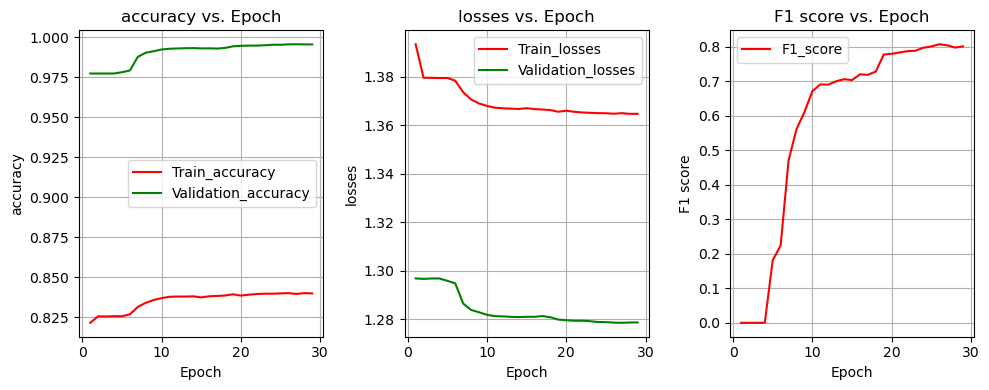

In [106]:
if device.type == 'cuda': torch.cuda.empty_cache() # Release cache

batch_size = 64
hidden_dim = 512
epoch = 50

# Get dataset loaders
train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(batch_size, ner_label_mapping)
test_data_loader, test_sentence_len = get_test_data(batch_size, ner_label_mapping)

# Initialize EarlyStopper and model
early_stopper = EarlyStopper(patience=3)
model = get_attention_ner_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)

# Train the model
train_accuracies, val_accuracies, train_losses, val_losses, f1_score_arr, time_taken = train_model(model, train_data_loader, 
    val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=True)

# Test the model
test_accuracy, f1_score, y_true_tags, y_pred_tags = test_model(model, test_data_loader, test_sentence_len, device)

# Plot findings
plot_findings(len(train_accuracies), [[train_accuracies, val_accuracies], [train_losses, val_losses], [f1_score_arr]], "Epoch", isoptimal=True)